# 两种执行方式

## 1. 在jupyter中执行，使用 plt 画图

In [3]:
import scipy.io
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from d2l import torch as d2l
import numpy as np
import argparse
import datetime
import wandb 


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# 后面还要做混淆矩阵

# 参数解析器
parser = argparse.ArgumentParser()
parser.add_argument('--project_name', type=str, default='DSC_CNN_demo01', help='project_name')
parser.add_argument('--batch_size', type=int, default=32, help='size of each image batch')
parser.add_argument('--lr', type=float, default=0.001, help='learning rate')
parser.add_argument('--optim_type', type=str, default='Adam', help='Optimizer')
parser.add_argument('--epochs', type=int, default=100, help='epochs')
parser.add_argument('--model_pth_name', type=str, default='../save/model_default.pth', help='pth_name')
# 不会解析命令行参数
args = parser.parse_args([])
# 返回一个NameSpace对象

def min_max_normalize(data, dim=-1):
    """
    对输入数据在指定维度上进行 Min - Max 归一化
    """
    min_vals = data
    min_vals, _ = torch.min(min_vals, dim=dim, keepdim=True)
    max_vals = data
    max_vals, _ = torch.max(max_vals, dim=dim, keepdim=True)
    
    denominator = max_vals - min_vals
    denominator[denominator == 0] = 1e-8
    
    normalized_data = (data - min_vals) / denominator
    return normalized_data

def create_input_iamge(data, length):
    num = data.size//(length**2)
    data = data[:num*(length**2)].reshape((num, 1, length, length))
    data = torch.tensor(data, dtype=torch.float32)
    # Max-Min 归一化
    data = min_max_normalize(data, dim=-1)
    return data

def create_dataloaders(length, Data_names, Data_names_key, Labels, data_path, is_train=1, batch_size = args.batch_size):
    for i in range(len(Data_names)):
        print('正在读取：' + Data_names[i])
        mat_data = scipy.io.loadmat(data_path + Data_names[i])
        numpy_X =  np.squeeze(mat_data[Data_names_key[i]])
        print('ndarry 形状：', numpy_X.shape)
        tensor_X = create_input_iamge(numpy_X, length)
        tensor_y = torch.full((tensor_X.shape[0],), Labels[i], dtype=torch.int64)
        print('tensor 形状：', tensor_X.shape)
        if i==0:
            X = tensor_X
            y = tensor_y
        else:
            # dim是轴而不是方向i
            X = torch.cat([X, tensor_X], dim=0)
            y = torch.cat([y, tensor_y], dim=0)
    print('模型输入的 tensor 形状为：', X.shape)
    print('对应标签的 tensor 形状为：', y.shape)
    
    dataset = TensorDataset(X, y)
    if is_train:
        train_size = int(0.7 * len(dataset))
        val_size = len(dataset) - train_size
        # 随机73划分数据集
        train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
        # Dataloader类型具有__iter__()方法，在迭代时会返回一个迭代器
        train_dataloader = DataLoader(
            train_dataset,
            batch_size=batch_size,
            shuffle=True,
            num_workers=2,
            drop_last=True
        )
        val_dataloader = DataLoader(
            val_dataset,
            batch_size=batch_size,
            shuffle=True,
            num_workers=2,
            drop_last=True
        )
        return train_dataloader, val_dataloader
    
    else:
        infer_dataloader = DataLoader(
            dataset,
            batch_size=batch_size,
            shuffle=False,
            num_workers=2,
            drop_last=True
        )
        return infer_dataloader

正在读取：normal_0
ndarry 形状： (243938,)
tensor 形状： torch.Size([238, 1, 32, 32])
正在读取：IR007_0
ndarry 形状： (121535,)
tensor 形状： torch.Size([118, 1, 32, 32])
正在读取：B007_0
ndarry 形状： (121168,)
tensor 形状： torch.Size([118, 1, 32, 32])
正在读取：OR007@6_0
ndarry 形状： (121168,)
tensor 形状： torch.Size([118, 1, 32, 32])
正在读取：OR007@3_0
ndarry 形状： (120984,)
tensor 形状： torch.Size([118, 1, 32, 32])
正在读取：OR007@12_0
ndarry 形状： (121168,)
tensor 形状： torch.Size([118, 1, 32, 32])
模型输入的 tensor 形状为： torch.Size([828, 1, 32, 32])
对应标签的 tensor 形状为： torch.Size([828])
torch.Size([32, 1, 32, 32])
tensor(2)


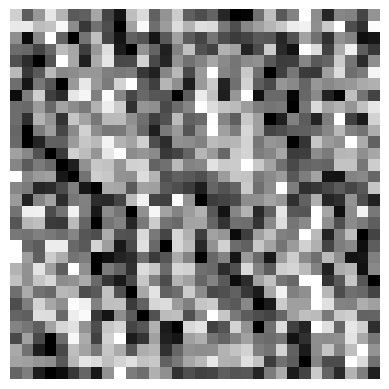

In [2]:
# Normal_0
# 风扇端12k: 007 0负载 1797rpm 内圈 IR007_0 滚动体 B007_0 外圈 OR007@6_0 OR007@3_0 OR007@12_0
# 每个文件内数据为 (243938, 1)
# 保证 Labels 和 Data_names一一对应
Data_names = ['normal_0', 'IR007_0', 'B007_0', 'OR007@6_0', 'OR007@3_0', 'OR007@12_0']
Data_names_key = ['X097_FE_time', 'X278_FE_time', 'X282_FE_time', 'X294_FE_time', 'X298_FE_time', 'X302_FE_time']
Labels = [0, 1, 3, 2, 2, 2]
train_dataloader, val_dataloader = create_dataloaders(32, Data_names, Data_names_key, Labels, '../data/CWRU/')
# 在train中已被包含，这里仅作演示

'''
验证及查看数据
'''
import torch
import matplotlib.pyplot as plt

index = 6
for batch_X, batch_y in train_dataloader:
    print(batch_X.shape)
    print(batch_y[index])
    # 调整张量形状，去除多余维度
    image = batch_X[index,:].squeeze()
    break

# 显示灰度图
plt.imshow(image, cmap='gray')
plt.axis('off')  # 不显示坐标轴
plt.show()

In [3]:
# 定义深度可分离卷积层
class DepthwiseSeparableConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1):
        super(DepthwiseSeparableConv, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=kernel_size, padding=padding, groups=in_channels)
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1)
    
    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x

# 定义Fire模块
class FireModule(nn.Module):
    def __init__(self, in_channels, squeeze_channels, expand_channels):
        super(FireModule, self).__init__()
        self.squeeze = nn.Conv2d(in_channels, squeeze_channels, kernel_size=1)
        self.expand1x1 = nn.Conv2d(squeeze_channels, expand_channels, kernel_size=1)
        self.expand3x3 = nn.Conv2d(squeeze_channels, expand_channels, kernel_size=3, padding=1)
    
    def forward(self, x):
        x = self.squeeze(x)
        x = torch.relu(x)
        return torch.cat([
            torch.relu(self.expand1x1(x)),
            torch.relu(self.expand3x3(x))
        ], 1)

# 定义卷积神经网络
class DSC_CNN(nn.Module):
    def __init__(self):
        super(DSC_CNN, self).__init__()
        self.layer1 = DepthwiseSeparableConv(1, 32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fire = FireModule(32, 16, 32)
        self.concat_conv = DepthwiseSeparableConv(64, 64) # 64 because FireModule output is concatenated
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(p=0.5) # 推理时默认不会调用
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(64, 4)
        # self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        x = self.layer1(x)
        x = torch.relu(x)
        x = self.pool1(x)
        x = self.fire(x)
        x = self.concat_conv(x)
        x = torch.relu(x)
        x = self.pool2(x)
        x = self.dropout(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        # 改动1：避免softmax重复计算
        # x = self.softmax(x) 
        return x

In [4]:
def train_epoch(model, dataloader, optimizer):
    model.train()
    for step, batch in enumerate(dataloader):
        features, labels = batch
        features, labels = features.to(device),labels.to(device)

        preds = model(features)
        loss = nn.CrossEntropyLoss()(preds,labels)        
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()
    return loss, model

def eval_epoch(model, dataloader):
    model.eval()
    accurate = 0
    num_elems = 0
    loss = 0
    num_batches = 0
    for batch in dataloader:
        features,labels = batch
        features,labels = features.to(device),labels.to(device)
        with torch.no_grad():
            preds = model(features)
        loss_batch = nn.CrossEntropyLoss()(preds, labels)
        loss += loss_batch
        num_batches += 1
        predictions = preds.argmax(dim=-1)
        accurate_preds = (predictions==labels)
        num_elems += accurate_preds.shape[0]
        accurate += accurate_preds.long().sum()# bool值转化为long
        
    val_acc = accurate.item() / num_elems
    loss = loss / num_batches
    return val_acc, loss

def train(args = args):
    Data_names = ['normal_0', 'IR007_0', 'B007_0', 'OR007@6_0', 'OR007@3_0', 'OR007@12_0']
    Data_names_key = ['X097_FE_time', 'X278_FE_time', 'X282_FE_time', 'X294_FE_time', 'X298_FE_time', 'X302_FE_time']
    Labels = [0, 1, 3, 2, 2, 2]
    train_dataloader, val_dataloader = create_dataloaders(32, Data_names, Data_names_key, Labels, '../data/CWRU/')
    
    model = DSC_CNN()
    model.to(device)
    optimizer = torch.optim.__dict__[args.optim_type](params=model.parameters(), lr=args.lr)
    #======================================================================
    # nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    # wandb.init(project=args.project_name, config = args.__dict__, name = nowtime, save_code=True)
    # model.run_id = wandb.run.id
    #======================================================================    
    # model.best_metric = -1.0
    train_loss_list = []
    val_loss_list = []
    val_acc_list = []
    for epoch in range(1,args.epochs+1):
        train_loss, model = train_epoch(model, train_dataloader, optimizer)
        val_acc, val_loss = eval_epoch(model, val_dataloader)
        train_loss_list.append(train_loss.item())
        val_loss_list.append(val_loss.item())
        val_acc_list.append(val_acc)
        # if val_acc > model.best_metric:
        #     model.best_metric = val_acc
        #     torch.save(model.state_dict(),config.ckpt_path)   
        nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        if epoch % 10 == 0:
            print(f"epoch【{epoch}】@{nowtime} --> val_acc= {100 * val_acc:.2f}%")
        
        #======================================================================
        # wandb.log({'train_loss':train_loss, 'val_loss':val_loss, 'val_acc': val_acc})
        #======================================================================        
    # print(train_loss_list, val_loss_list, val_acc_list)
    d2l.plot(list(range(1, args.epochs + 1)), [train_loss_list, val_loss_list, val_acc_list],
         xlabel='epoch', ylabel='loss', xlim=[1, args.epochs], ylim=[0, 2],
         legend=['train_loss', 'valid_loss', 'valid_acc'], yscale='linear')
    
    torch.save(model.state_dict(), args.model_pth_name)
    # wandb.finish()
    return model

正在读取：normal_0
ndarry 形状： (243938,)
tensor 形状： torch.Size([238, 1, 32, 32])
正在读取：IR007_0
ndarry 形状： (121535,)
tensor 形状： torch.Size([118, 1, 32, 32])
正在读取：B007_0
ndarry 形状： (121168,)
tensor 形状： torch.Size([118, 1, 32, 32])
正在读取：OR007@6_0
ndarry 形状： (121168,)
tensor 形状： torch.Size([118, 1, 32, 32])
正在读取：OR007@3_0
ndarry 形状： (120984,)
tensor 形状： torch.Size([118, 1, 32, 32])
正在读取：OR007@12_0
ndarry 形状： (121168,)
tensor 形状： torch.Size([118, 1, 32, 32])
模型输入的 tensor 形状为： torch.Size([828, 1, 32, 32])
对应标签的 tensor 形状为： torch.Size([828])
epoch【10】@2025-04-21 20:28:25 --> val_acc= 68.75%
epoch【20】@2025-04-21 20:28:28 --> val_acc= 70.09%
epoch【30】@2025-04-21 20:28:32 --> val_acc= 67.41%
epoch【40】@2025-04-21 20:28:35 --> val_acc= 71.88%
epoch【50】@2025-04-21 20:28:38 --> val_acc= 76.34%
epoch【60】@2025-04-21 20:28:42 --> val_acc= 78.12%
epoch【70】@2025-04-21 20:28:45 --> val_acc= 77.68%
epoch【80】@2025-04-21 20:28:48 --> val_acc= 80.36%
epoch【90】@2025-04-21 20:28:52 --> val_acc= 89.29%
epoch【100】@2025-

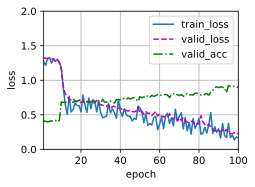

In [5]:
args.model_pth_name = '../save/model_222.pth'
args.epochs = 100
model = train(args)

## 2. 使用命令行执行，wandB监视(不建议使用)


In [ ]:
# 到终端使用，这里无法填写密码
!python model.py --batch_size 32 --lr 0.001 --optim_type 'Adam' --epochs 100 --model_pth_name '../save/model02.pth'

## 3. 预测


In [53]:
Data_names = ['normal_0', 'IR007_0', 'B007_0', 'OR007@6_0']
Data_names_key = ['X097_FE_time', 'X278_FE_time', 'X282_FE_time', 'X294_FE_time']
Labels = [0, 1, 3, 2]
pre_dataloaders = create_dataloaders(32, Data_names, Data_names_key, Labels, '../data/CWRU/', is_train=0)
# 查看一batch_size的数据
next(pre_dataloaders.__iter__())[0].shape, next(pre_dataloaders.__iter__())[1].shape

正在读取：normal_0
[0.14566727 0.09779636 0.05485636 ... 0.14053091 0.09553636 0.09019455] 243938
ndarry 形状： (243938,)
tensor 形状： torch.Size([238, 1, 32, 32])
正在读取：IR007_0
[-0.05121818 -0.19219013  0.05121818 ... -0.04097455 -0.00276416
  0.55234338] 121535
ndarry 形状： (121535,)
tensor 形状： torch.Size([118, 1, 32, 32])
正在读取：B007_0
[ 0.31966649  0.32617039 -0.26048104 ...  0.02975532  0.13950857
  0.05544571] 121168
ndarry 形状： (121168,)
tensor 形状： torch.Size([118, 1, 32, 32])
正在读取：OR007@6_0
[ 0.12723247 -0.25893636 -0.05975455 ... -0.20609221  0.12804545
  0.01747922] 121168
ndarry 形状： (121168,)
tensor 形状： torch.Size([118, 1, 32, 32])
模型输入的 tensor 形状为： torch.Size([592, 1, 32, 32])
对应标签的 tensor 形状为： torch.Size([592])


(torch.Size([32, 1, 32, 32]), torch.Size([32]))

In [61]:
acc,_ = eval_epoch(model, pre_dataloaders)
acc

0.0

In [7]:
Data_names = ['200_0', '100_1', '100_2_0']
Data_names_key = [ 'dataset', 'dataset', 'dataset']
Labels = [0, 1, 2]
args.batch_size = 400
pre_dataloaders = create_dataloaders(32, Data_names, Data_names_key, Labels, '../data/dataset02/', is_train=0, batch_size=args.batch_size)
# 查看一batch_size的数据
next(pre_dataloaders.__iter__())[0].shape, next(pre_dataloaders.__iter__())[1].shape

正在读取：200_0
ndarry 形状： (204800,)
tensor 形状： torch.Size([200, 1, 32, 32])
正在读取：100_1
ndarry 形状： (102400,)
tensor 形状： torch.Size([100, 1, 32, 32])
正在读取：100_2_0
ndarry 形状： (102400,)
tensor 形状： torch.Size([100, 1, 32, 32])
模型输入的 tensor 形状为： torch.Size([400, 1, 32, 32])
对应标签的 tensor 形状为： torch.Size([400])


(torch.Size([400, 1, 32, 32]), torch.Size([400]))

torch.Size([400, 1, 32, 32])
tensor(1)


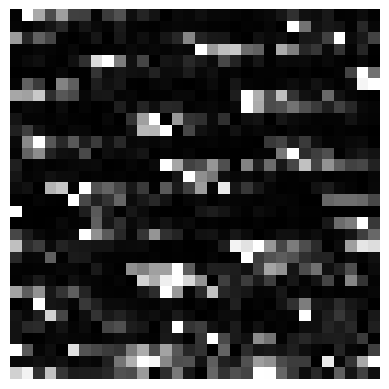

In [27]:
'''
验证及查看数据
'''
import torch
import matplotlib.pyplot as plt

index = 289
for batch_X, batch_y in pre_dataloaders:
    print(batch_X.shape)
    print(batch_y[index])
    # 调整张量形状，去除多余维度
    image = batch_X[index,:].squeeze()
    break

# 显示灰度图
plt.imshow(image, cmap='gray')
plt.axis('off')  # 不显示坐标轴
plt.show()
# '''
# 不重要
# '''